This kernel is inspired by Heng's [discussion](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/106462#latest-618693), which is about [HRNet-Semantic-Segmentation](https://arxiv.org/abs/1904.04514)
![](https://raw.githubusercontent.com/HRNet/HRNet-Semantic-Segmentation/master/figures/seg-hrnet.png?generation=1565963628491533&amp;alt=media)


In [1]:
from HRNet.c1_decoder import get_decoder, C1DeepSup
from HRNet.hrnet import get_encoder
from HRNet.resnet import resnet18, resnet50
from HRNet.model import Resnet_OCR
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import cv2
from PIL import Image
import scipy.io
import matplotlib.pylab as plt
import glob
from tqdm import tqdm

In [2]:
def transform(image, size):
    resize = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
    return resize(Image.fromarray(np.uint8(image))).unsqueeze(0)

In [3]:
def show(output, colors):
    final = output[0].detach().numpy()
    classes = np.argmax(final, axis=0)
    mask = colors[classes]
    print(mask.shape)
    plt.imshow(mask)
#     plt.show()

In [4]:
encoder = resnet18('resnet18-imagenet.pth')

In [5]:
decoder = get_decoder(59, 960, '')

In [6]:
size = (800, 544)
size_label = (200, 136)

In [7]:
colors = scipy.io.loadmat('color150.mat')['colors']

In [8]:
output_folder = f'data/annotations/pixel-level/'
input_folder = f'data/photos/'
num = 1004

In [9]:
inputs = [transform(Image.open(x), size) for x in sorted(glob.glob(f'{input_folder}*.jpg'))[:num]] # 1004

In [10]:
labels = [(255 * transform(scipy.io.loadmat(x)['groundtruth'], size_label)).type(torch.LongTensor) 
          for x in sorted(glob.glob(f'{output_folder}*.mat'))[:num]]

In [11]:
dataset = TensorDataset(torch.cat(inputs), torch.cat(labels))

In [12]:
train_dataset, test_dataset = random_split(dataset, (803, 201))

In [13]:
model = Resnet_OCR(encoder, decoder, size)
# model.EncoderDecoder.load_state_dict(torch.load('model.pkl'))

In [14]:
def measure_accuracy(model, dataset):
    dataloader = DataLoader(dataset, 1, shuffle=False)
    count = 0
    correct = 0
    for data, target in dataloader:
        prediction = model(data, ocr=True)[1][0].detach().numpy()
        classes = np.argmax(prediction, axis=0)
        count += classes.shape[0] * classes.shape[1]
        comparison = (classes == target[0, 0].detach().numpy()).astype(int).flatten()
        correct += sum(comparison)
    return correct / count

In [15]:
def train(model, train_dataset, test_dataset, epochs=1, batch_size=64):
    dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), 3e-4)
    model.train()
    criterion = nn.NLLLoss(ignore_index=-1)
    losses = []
    for e in range(epochs):
        epoch_loss = 0
        count = 0
        for data, target in tqdm(dataloader, total=len(dataloader)):
            prediction = model(data)
            out_aux = prediction[0]
            out = prediction[1]
            soft_region_loss = criterion(out_aux, target.squeeze(1))
            ocr_loss = criterion(out, target.squeeze(1))
            loss = soft_region_loss + ocr_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count += 1
            epoch_loss += loss
        losses.append(epoch_loss.item() / count)
        name = 'model_ocr' + str(e+1) + 'pkl'
        torch.save(model.state_dict(), name)
        # accuracies.append(model, test_dataset)
        print(f'epoch {e+1} loss: {epoch_loss.item() / count}')
    return losses, accuracies

In [ ]:
losses, accuracies = train(model, train_dataset, test_dataset, epochs=10, batch_size=16)

  0%|          | 0/51 [00:00<?, ?it/s]

epoch 1 loss: 4.948095583448223


  0%|          | 0/51 [00:00<?, ?it/s]

epoch 2 loss: 2.6770677753523286


 24%|██▎       | 12/51 [1:15:20<4:07:19, 380.49s/it]

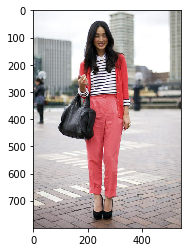

In [382]:
num = 96
example = dataset[num][0].unsqueeze(0)
example.shape
plt.imshow(example[0].permute((1, 2, 0)))

(200, 136, 3)


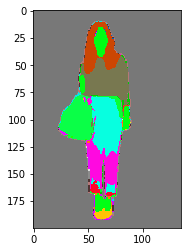

In [383]:
prediction = model(example, ocr=True, segSize=False)
show(prediction[1], colors)

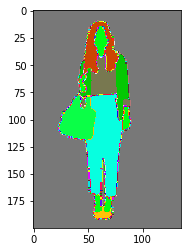

In [384]:
lab = labels[num][0][0]
truth = colors[lab]
plt.imshow(truth, cmap='gray')

In [223]:
measure_accuracy(model, dataset, size_label)

0.859973415162878

In [385]:
torch.save(model.state_dict(), 'model_ocr.pkl')